# AI For Competitive Advantage
Today we'll explore Support Vector Machines (SVM), which are a form of supervised
learning that produce classification boundaries like logistic regression or
random forests. It's another tool in the tool belt when we want to classify
our data. More specifically, we'll learn about two characteristics of
SVMs: the hyperplane and maximal margin classifier. And, we'll learn how to
implement a SVM with our data. 

## Infrastructure
We'll load libraries and pre-built functions for later use here:

In [1]:

from sklearn.datasets import load_boston
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
%matplotlib inline

def norm_data(X):

    scaler = StandardScaler().fit(X)
    X_norm = scaler.transform(X)

    return X_norm
def pca_transform(n, data, inv = False):
    pca = PCA(n_components = n, random_state = 0)
    data_norm = norm_data(data)

    if inv:
        Z = pca.inverse_transform(Z)*data.std(axis=0) + data.mean(axis=0)
    else:
        Z = pca.fit_transform(data_norm)

    return Z
def visualizeBoundary(X, y, model, plot_name, plot_num=None, 
                      plot_support=True, toy=False):

    if plot_num != None:
        plt.subplot(1,3, plot_num)

    # Make classification predictions over a grid of values
    x1plot = np.linspace(min(X[:,0]), max(X[:,0]), 100)
    x2plot = np.linspace(min(X[:,1]), max(X[:,1]), 100)
    X1, X2 = np.meshgrid(x1plot, x2plot)
    x12 = np.vstack([X1.ravel(), X2.ravel()]).T
    #vals = model.predict(x12).reshape(X1.shape)
    if isinstance(model, SVC):
        vals = model.decision_function(x12).reshape(X1.shape)
    else:
        vals = model.predict(x12).reshape(X1.shape)

    # Plot the SVM boundary
    pos =np.where(y == 1)[0] 
    neg =np.where(y == 0)[0] 

    plt.scatter(X[pos, 0], X[pos, 1], marker='+',linewidth= 1, 
                label = 'greater than MEDV') 
    plt.scatter(X[neg, 0], X[neg, 1], marker='.',linewidth= 1, 
                label = 'less than MEDV') 
    if plot_num != None:
        plt.contour(X1, X2, vals, colors = 'k',
                levels = [0], alpha=0.5)
                #levels = [-1, 0, 1], alpha=0.5,
                #linestyles=['--', '-', '--'])
    else:
        plt.contour(X1, X2, vals, colors = 'k',
                levels = [-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])

    if plot_support and isinstance(model, SVC):
        plt.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                    s=300, linewidth=1, facecolors='none',
                    edgecolors='b')
    fig = plt.gcf()
    plt.tight_layout()

    plt.title(plot_name)
    if not toy:
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    plt.subplots_adjust(top=0.88, bottom=0.08, left=0.10, right=0.95, 
                        hspace=0.25, wspace=0.35)
    if (plot_num == 1 or plot_num == None) and not toy:
        plt.legend(prop={'size': 6})

    if plot_num != None:
        plt.text(-5,-3.2,'Accuracy = %.2f' % model.score(X,y))
        plt.suptitle('Boston Housing: Different Classifiers')

    plt.show()

## Hyperplane
A hyperplane is a subspace whose dimension is one less than that of its ambient
space. Let's define what the hyperplane would be in different ambient spaces:

- A line: the hyperplane would be a point
- A 2D space (think (x,y) plane): the hyperplane would be a line
    - every decision boundary we've graphed as a line previously could also be
      called a hyperplane
- A 3D space (think our graph of 3 Principal Components for Boston Housing):
  the hyperplane would be a 2D plane. 

There are hyperplanes in higher dimensions, but we won't see them in practice
because we can't visualize anything beyond 3D spaces. 

## Support Vector Machine
We'll next learn about the fundamentals of the SVM

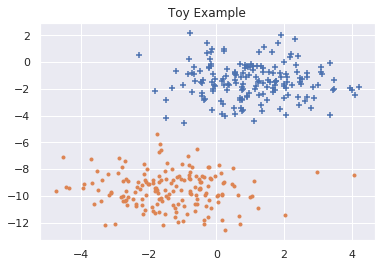

In [2]:
# toy example no classifier
X, y = make_blobs(n_samples=340, centers = 2,
                  random_state=2, cluster_std=1.3)
pos = y==1; neg = y==0
plt.title('Toy Example')
plt.scatter(X[pos, 0], X[pos,1], marker='+')
plt.scatter(X[neg, 0], X[neg,1], marker='.')

There are many hyperplanes (lines in this case) you could draw that would 
seperate the two groups of data. For each line chosen, there is a margin
between it and the nearest point from each group. SVM chooses the line that 
maximizes these distances, which is why it's called a maximum margin
classifier.

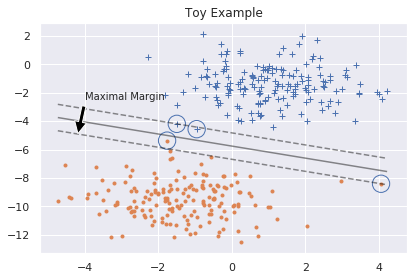

In [3]:
# toy example with classifier
X, y = make_blobs(n_samples=340, centers = 2,
                  random_state=2, cluster_std=1.3)
clf = SVC(kernel='linear')
clf.fit(X, y)
ax = plt.gca()
ax.annotate('Maximal Margin', xy=(-4.2, -5), xytext=(-4, -2.5),
            arrowprops=dict(facecolor='black', shrink=0.05))
visualizeBoundary(X,y, clf, 'Toy Example', toy=True)

The solid line is the decision boundary found by SVM. The distance between the
dotted lines is the maximal margin found by the SVM. And, the circles are the 
support vectors, which are used to find the boundary that has the greatest
distance seperating the nearest points from the decision boundary, the maximal
margin.

When we used linear and logistic regression, the distance from each point to
the decision boundary was important. So, if there was an outlier far different
from the other points, it had a large effect on our resulting decision
boundary.

In opposition, A SVM doesn't take into account all data points when drawing a 
boundary like we saw with linear or logistic regression. It only considers the 
location of the support vectors. The result is SVM is much less sensitive to 
outlier data compared to other methods, which is its  strength. 

To make this more concrete, say our Boston Housing data had the CEO of GE's 
home included. His home is very expensive, so if we were looking for a decision
boundary between homes greater and less than the median (MEDV), this outlier
would pull the decision boundaries of linear and logistic regression toward it
causing a distortion. In contrast, the CEO's home wouldn't cause the same
distortion with a SVM because it only uses the support vectors, in the center
of the data, to create a boundary. This makes the SVM boundary more accurate
compared to linear or logistic regression in the presence of outliers.

## Regularization

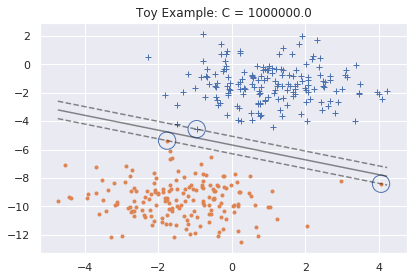

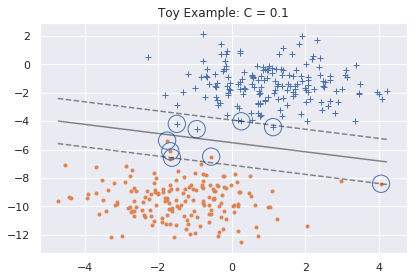

In [4]:
# toy example relaxing maximum margins with varying C parameter
for C in [1e6, .1]:
    clf = SVC(C=C, kernel='linear')
    clf.fit(X, y)
    title = 'Toy Example: C = {}'.format(C)
    visualizeBoundary(X,y, clf, title, toy=True)

The C parameter has a similar function in SVM as the regularization parameter,
lambda, in linear and logistic regression. We can control how strict the maximum margins are through the C parameter of
the SVM. The larger C is the stricter the dotted line boundaries. Likewise, the
smaller C is the looser the dotted line boundaries become.

## Exercise: Boston Housing
Let's see how this new method works with the Boston Housing data and other
methods we've previously used. Graph the SVM boundary on the first two
principal components of the Boston Housing data.

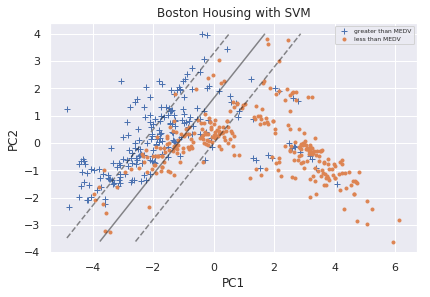

In [5]:
# graph of SVM on 2D Boston Housing data

boston = load_boston()
X = boston.data
y = boston.target
# greater or less than mean for target variable
y_mean = np.where(y > y.mean(), 1, 0)
#------------------Enter Your Code Here-----------------#
X_2D = pca_transform(2, X)
clf = SVC(C=1, kernel='linear')
clf.fit(X_2D, y_mean)
title = "Boston Housing with SVM"
visualizeBoundary(X_2D,y_mean, clf, title, plot_support=False)
#-------------------------------------------------------#

## Conclusion
We saw that the SVM uses the support vectors to create a seperating hyperplane
with maximal margins around the seperated groups. The advantages of SVM are:

- They only rely on the support vectors to come up with a classification. This
  makes them more resistant to outliers
- They can classify data with nonlinear boundaries if needed. 

The disadvtantages of SVMs are:

- You need to carefully choose the C parameter, which can be expensive to find
  for larger datasets.
- You can't interpret the results as a probability like logistic regression.

In sum, it's best to leave SVM to more complicated situations after simpler
approaches are exhausted.